In [105]:
# !pip install CMake
# !pip install dlib
# !pip install face_recognition
# !pip install mlxtend  
# !pip install imageio
# !pip install opencv-python

In [1]:
# import dlib
import cv2
import numpy as np
import imageio
import matplotlib.pyplot as plt
from mlxtend.image import extract_face_landmarks
import plotly.express as px
import scipy.io as sio
import os
import pandas as pd
import mediapipe as mp

%matplotlib inline

## learning Area

In [205]:
# test_img = './AFLW2000/image00002.jpg'
# my_img = '/home/mahmoud/Pictures/Webcam/me.jpeg'
# img = imageio.imread(my_img)
# landmarks = extract_face_landmarks(img)
# print(landmarks.shape)
# print('\n\nFirst 10 landmarks:\n', landmarks[:10])

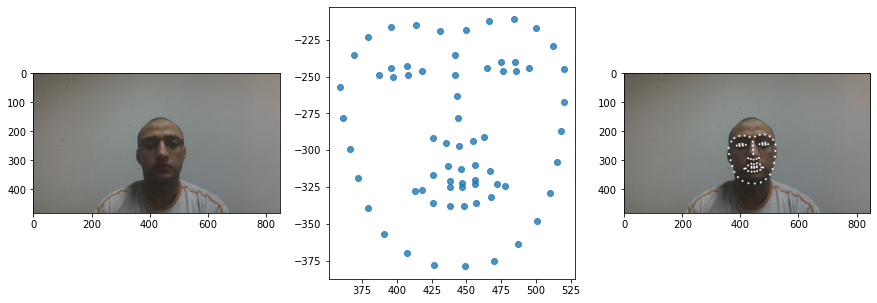

In [54]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(landmarks[:, 0], -landmarks[:, 1], alpha=0.8)
ax = fig.add_subplot(1, 3, 3)
img2 = img.copy()

for p in landmarks:
    img2[p[1]-3:p[1]+3, p[0]-3:p[0]+3, :] = (255, 255, 255)
    # note that the values -3 and +3 will make the landmarks
    # overlayed on the image 6 pixels wide; depending on the
    # resolution of the face image, you may want to change
    # this value

ax.imshow(img2)
plt.show()

In [206]:
# plt.scatter(landmarks[:, 0], -landmarks[:, 1], alpha=0.8)

In [3]:
# px.scatter(x = landmarks[:, 0], y = -landmarks[:, 1])

## Loading Data

In [3]:
mat_files = []
pic_files = []
for i in os.scandir('./AFLW2000/'):
    if i.path.endswith('mat'):
        mat_files.append(i.path)
    elif i.path.endswith('jpg'):
        pic_files.append(i.path)

In [8]:
pic_files[0]

'./AFLW2000/image02494.jpg'

In [9]:
test_pd = pd.DataFrame(columns = list(range(1,137))+['Yaw','Pitch','Roll'])

In [13]:
# ! pip install mediapipe

In [17]:
mp_face_mesh = mp.solutions.face_mesh
img_test = plt.imread(pic_files[0])
mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
results = mesh.process(img_test)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [32]:
for face in results.multi_face_landmarks:
    for landmark in face.landmark:
        x = landmark.x
        y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
#               shape = image.shape 

In [65]:
def creat_landmks(imgs, mats):
    # creat data frame to hold data
    df = pd.DataFrame(columns = list(range(1,469*2 + 1))+['Yaw','Pitch','Roll'])
    row = 0
    for im, mat in zip(imgs,mats):
        data_list = []
        # landmarks part
        image = plt.imread(im)
        mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
        results = mesh.process(image)
        if results.multi_face_landmarks != None:
            face = results.multi_face_landmarks[0]
            for landmark in face.landmark:
                data_list.append(landmark.x)
                data_list.append(landmark.y)
#         print(len(data_list))
        # 3 angles part
            f = sio.loadmat(mat)
            ypr = f['Pose_Para'][0][:3]
            data_list.append(ypr)
            df[row] = data_list
            row += 1
    return df
        
    

In [66]:
df = creat_landmks(pic_files, mat_files)

IsADirectoryError: [Errno 21] Is a directory: './AFLW2000/Code'

In [224]:
cent_test = test_file['pt3d_68'][0:2,:]

In [230]:
cent_test /(cent_test[:,34:35] - cent_test[:,23:24]) 

array([[ -4.6473794,  -4.7270823,  -4.878423 ,  -5.053157 ,  -5.3526335,
         -5.7909613,  -6.4118166,  -7.2021656,  -8.3371725,  -9.500751 ,
        -10.339121 , -10.995223 , -11.497042 , -11.817255 , -12.016127 ,
        -12.193868 , -12.278383 ,  -5.2997775,  -5.735482 ,  -6.338171 ,
         -6.8701854,  -7.3613734,  -9.136817 ,  -9.628561 , -10.161677 ,
        -10.799127 , -11.3091545,  -8.256711 ,  -8.258673 ,  -8.261081 ,
         -8.260933 ,  -7.6590757,  -7.948868 ,  -8.293375 ,  -8.628561 ,
         -8.915454 ,  -6.0181494,  -6.34824  ,  -6.830279 ,  -7.300315 ,
         -6.8650513,  -6.367998 ,  -9.224629 ,  -9.68081  , -10.1855   ,
        -10.589706 , -10.190534 ,  -9.654923 ,  -6.9645686,  -7.27483  ,
         -7.928807 ,  -8.295222 ,  -8.648819 ,  -9.244631 ,  -9.538291 ,
         -9.133565 ,  -8.732176 ,  -8.310616 ,  -7.890048 ,  -7.440436 ,
         -7.095619 ,  -7.8611083,  -8.281095 ,  -8.681461 ,  -9.449625 ,
         -8.673848 ,  -8.276949 ,  -7.88685  ],
   

In [236]:
def create_data(files):
    '''
    create data frame from matlab file in the data to train the model 
    '''
    df = pd.DataFrame(columns = list(range(1,137))+['Yaw','Pitch','Roll'])
    for idx, file in enumerate(files):
        # load the mat file
        f = sio.loadmat(file)
        # extract the x,y data of face 68 point and flatten to add to the dataframe
        landmarks = f['pt3d_68'][0:2,:]
        # centirng the data around point 52
        landmarks = landmarks - landmarks[:,52:53]
        # fixing the scale for all poinst
        landmarks = landmarks /np.sqrt((landmarks[:,34:35] - landmarks[:,23:24])**2) 
        landmarks = landmarks.flatten().reshape(1,-1)
        # extract yaw pitch roll
        ypr = f['Pose_Para'][0][:3]
        # append to landmarks to insert into data frame
        landmarks_with_ypr = np.append(landmarks, ypr)
        # insert new data point (image)
        df.loc[idx] = landmarks_with_ypr
        
    df.reset_index(drop = True, inplace = True)
    return df
        
    
df = create_data(mat_files)  

features = df.drop(columns= ['Yaw','Pitch','Roll'])
y = df[['Yaw','Pitch','Roll']].copy()

from sklearn.preprocessing import StandardScaler
sts = StandardScaler().fit(features)
x = sts.transform(features)

In [232]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [237]:
x_train, x_val, y_train, y_val = train_test_split(x,y, random_state=0, test_size=.25)

In [238]:
model2 = MultiOutputRegressor(RandomForestRegressor())
model2.fit(x_train, y_train)
model2.score(x_val, y_val)

0.5334834218072908

In [239]:
model2 = MultiOutputRegressor(SVR(epsilon= 0,C=2.15 ))
model2.fit(x_train, y_train)
model2.score(x_val, y_val)

0.3098298965271124

In [88]:
from sklearn.model_selection import GridSearchCV

In [212]:
np.logspace(-3,2,10)

array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02])

In [214]:
parm_grid = {'estimator__epsilon': range(6),'estimator__C':np.logspace(-3,2,10), 'estimator__gamma':['scale','auto'] }
gs = GridSearchCV(MultiOutputRegressor(SVR()),param_grid= parm_grid )


In [215]:
gs.fit(x_train,y_train)

GridSearchCV(estimator=MultiOutputRegressor(estimator=SVR()),
             param_grid={'estimator__C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                         'estimator__epsilon': range(0, 6),
                         'estimator__gamma': ['scale', 'auto']})

In [217]:
gs.score(x_val,y_val)

0.7552345938253939

In [220]:
gs.best_params_

{'estimator__C': 2.1544346900318843,
 'estimator__epsilon': 0,
 'estimator__gamma': 'scale'}

In [203]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img # cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if i read the file with cv2 

In [155]:
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path

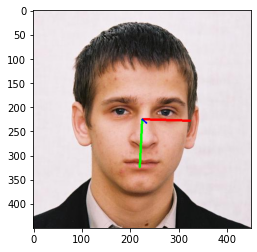

In [167]:
random_file = 'image00053'
image = cv2.imread('./AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('./AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
plt.imshow(draw_axis(image,pitch,yaw,roll))

In [240]:
my_img = '/home/mahmoud/Pictures/Webcam/me.jpeg'
img = imageio.imread(my_img)
landmarks = extract_face_landmarks(img)

In [244]:
landmarks.shape

(68, 2)

In [246]:
landmarks = landmarks - landmarks[52:53, :]
        # fixing the scale for all poinst
andmarks = landmarks /np.sqrt((landmarks[34:35,:] - landmarks[23:24,:])**2) 
my = gs.predict(landmarks.flatten().reshape(1,-1))

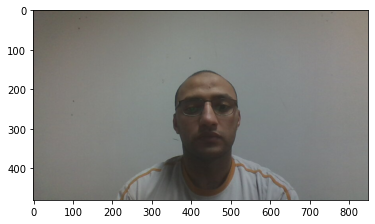

In [199]:
plt.imshow(img)

In [256]:
landmarks[51,1]

3

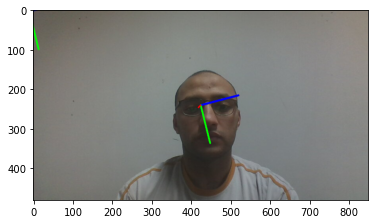

In [257]:
plt.imshow(draw_axis(img,my[0][0],my[0][1],my[0][2], landmarks[51,0], landmarks[51,1] ))

In [189]:
im = plt.imread(my_img)

In [195]:
t = imageio.imread(my_img)

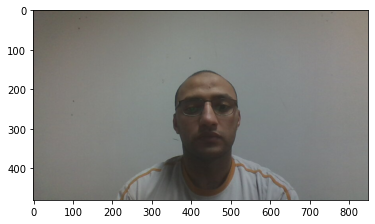

In [196]:
plt.imshow(t)

array([[128.48561  , 130.68915  , 134.87326  , 139.7041   , 147.9837   ,
        160.10211  , 177.26683  , 199.11752  , 230.49693  , 262.66626  ,
        285.8446   , 303.9838   , 317.8575   , 326.71042  , 332.20862  ,
        337.1226   , 339.4592   , 146.5224   , 158.56828  , 175.23076  ,
        189.9393   , 203.51913  , 252.60464  , 266.19983  , 280.93884  ,
        298.56235  , 312.66302  , 228.27243  , 228.32666  , 228.39325  ,
        228.38914  , 211.74968  , 219.76152  , 229.28609  , 238.55293  ,
        246.48463  , 166.38315  , 175.50912  , 188.83601  , 201.83105  ,
        189.79736  , 176.05539  , 255.03238  , 267.64435  , 281.59747  ,
        292.77252  , 281.73663  , 266.92868  , 192.5487   , 201.12646  ,
        219.2069   , 229.33714  , 239.11299  , 255.58536  , 263.70413  ,
        252.51472  , 241.41757  , 229.76273  , 218.13535  , 205.70496  ,
        196.17184  , 217.33525  , 228.94656  , 240.01547  , 261.2528   ,
        239.805    , 228.83194  , 218.04692  ],
   

In [ ]:
# calculation of yaw pitch roll
def rotationMatrixToEulerAngles(R) :
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z])

#returns pitch,yaw,roll [-1...+1]
def estimate_pitch_yaw_roll(aligned_256px_landmarks):
    shape = (256,256)
    focal_length = shape[1]
    camera_center = (shape[1] / 2, shape[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, camera_center[0]],
         [0, focal_length, camera_center[1]],
         [0, 0, 1]], dtype=np.float32)

    (_, rotation_vector, translation_vector) = cv2.solvePnP(
        landmarks_68_3D,
        aligned_256px_landmarks.astype(np.float32),
        camera_matrix,
        np.zeros((4, 1)) )

    pitch, yaw, roll = rotationMatrixToEulerAngles( cv2.Rodrigues(rotation_vector)[0] )
    pitch = np.clip ( pitch*1.25, -1.0, 1.0 )
    yaw = np.clip ( yaw*1.25, -1.0, 1.0 )
    roll = np.clip ( roll*1.25, -1.0, 1.0 )
    return pitch, yaw, roll